In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage, misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
root_dir = '/Users/zaimmusa/PycharmProjects/Machine_learning/SVHN'

In [3]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(path = root)
    tar.close()

maybe_extract(root_dir + '/data/train.tar.gz')
maybe_extract(root_dir + '/data/test.tar.gz')

/Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/train already present - Skipping extraction of /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/train.tar.gz.
/Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/test already present - Skipping extraction of /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/test.tar.gz.


TO DO: coverting from .mat to .csv

Read labels from csv files. How many examples do we have.

In [61]:
import csv
def read_csv(filename):
    with open(filename , 'rb') as f:
        reader = csv.reader(f)
        data_list = list(reader)
        
        d = {}
        for item in data_list:
            if not item[1].isdigit():
                continue
            if not item[0] in d:
                d[item[0]] = []
            d[item[0]].append([int(x) for x in item[1:]])
        return d, len(data_list)
    
def count_examples_by_digits(labels_dict):
    count = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
    for x in labels_dict:
        count[len(labels_dict[x])] = count[len(labels_dict[x])] + 1
    count = {c: 100.0*count[c]/len(labels_dict) for c in count}
    return count
    
    
labels_train_data_dict, training_digits = read_csv(root_dir + '/data/train/trainData.csv')
labels_test_data_dict, test_digits = read_csv(root_dir + '/data/test/testData.csv')
print ('Training dataset size ', len(labels_train_data_dict), ' with ',training_digits, ' digits.')
print ('Test datasset size ', len(labels_test_data_dict), ' with ',test_digits, ' digits.')

Training dataset size  33402  with  73258  digits.
Test datasset size  13068  with  26033  digits.


What is the distribution of examples by number of digits in them?
First for the training set.

1  digit 15.3793186037 %
2  digit 54.2781869349 %
3  digit 26.0194000359 %
4  digit 4.29315609844 %
5  digit 0.0269444943417 %
6  digit 0.00299383270463 %


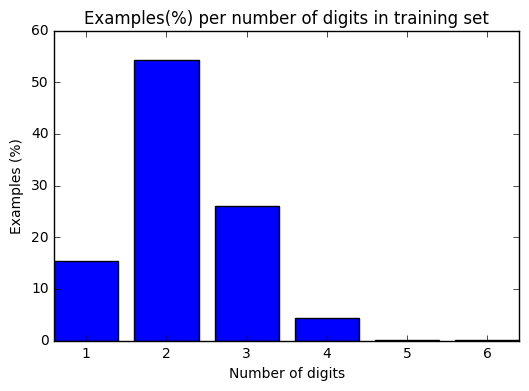

In [65]:
count_training = count_examples_by_digits(labels_train_data_dict)
for key in count_training:
    print (key, ' digit', count_training[key], '%')
plt.title('Examples(%) per number of digits in training set')
plt.xlabel('Number of digits')
plt.ylabel('Examples (%)')
plt.xticks(range(len(count_training)), count_training.keys())
plt.bar(range(len(count_training)), count_training.values(), align='center')
plt.show()

We see that there are more than 50% two digit examples, and there are very few examples with more than 4 digits.
Let's plot the same graph for test dataset.

1  digit 19.0006121824 %
2  digit 63.9424548515 %
3  digit 15.9243954699 %
4  digit 1.11723293541 %
5  digit 0.0153045607591 %
6  digit 0.0 %


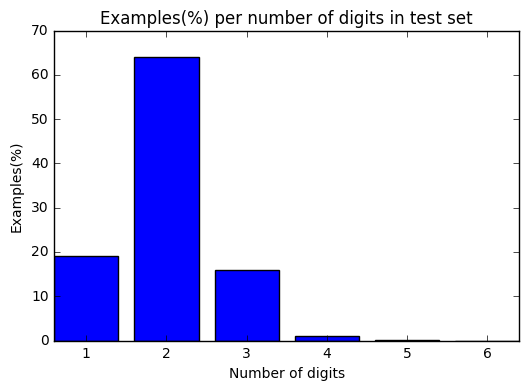

In [66]:
count_test = count_examples_by_digits(labels_test_data_dict)
for key in count_test:
    print (key, ' digit', count_test[key], '%')
plt.title('Examples(%) per number of digits in test set')
plt.xlabel('Number of digits')
plt.ylabel('Examples(%)')
plt.xticks(range(len(count_test)), count_test.keys())
plt.bar(range(len(count_training)), count_test.values(), align='center')
plt.show()

Set see that distribution is similar, with slightly more two digit numbers.

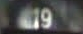

[[9, 41, 6, 12, 22], [7, 30, 7, 10, 22]]

In [29]:
from IPython.display import Image
display(Image(filename= root_dir + '/data/train/10855.png'))
labels_train_data_dict['10855.png']

image shape: (83, 167, 3)
[1, 10]
[[1, 48, 9, 32, 67], [10, 82, 13, 33, 67]]


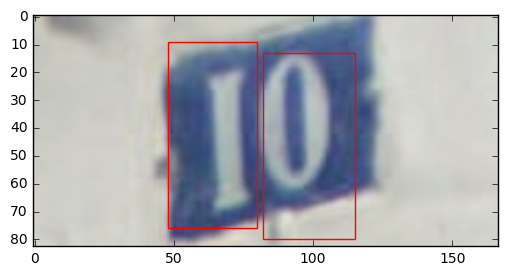

In [6]:
import matplotlib.patches as patches
from PIL import Image

to_display = '13068.png'

im = np.array(Image.open(root_dir + '/data/train/' + to_display), dtype=np.uint8)
# Create figure and axes
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(im)
print ('image shape:', im.shape)
for digit_loc in labels_train_data_dict[to_display]:
    # Create a Rectangle patch
    rect = patches.Rectangle((digit_loc[1],digit_loc[2]),digit_loc[3],digit_loc[4],linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
labels_train_data_dict[to_display].sort(key=lambda x: x[1])
print ([d[0] for d in labels_train_data_dict[to_display]])
print (labels_train_data_dict[to_display])
plt.show()

This function calculates minimum rectangle that contains all digits. 

In [67]:
def get_rectangle_containing_all_digits(digits):
    x = max(0, min([d[1] for d in digits]))
    y = max(0, min([d[2] for d in digits]))
    w = max([d[1] + d[3] - x for d in digits])
    h = max([d[2] + d[4] - y for d in digits])
    return x, y, w, h


Let's analyse cropped image sizes. This could be relevant to input image size to use in my model.

Percentage of croped images with size less or equal to 2000 pixels  76.495419436
Percentage of croped images with size less or equal to 1500 pixels  68.7952817197


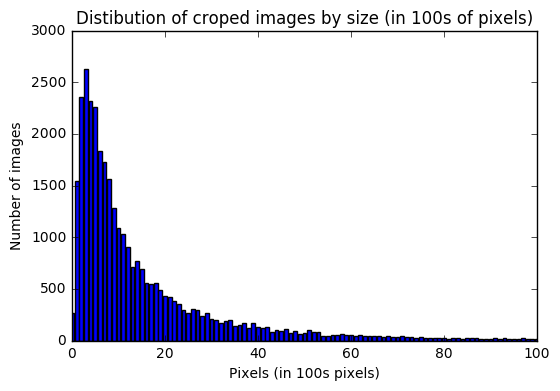

In [89]:
crop_size = {}
for image in os.listdir(root_dir + '/data/train/'):
    image_file = os.path.join(root_dir + '/data/train/', image)
    if not image.endswith('.png'):
        continue
    try:
        #image_orig = ndimage.imread(image_file, flatten=True)
        labels_train_data_dict[image].sort(key=lambda x: x[1])
        x, y, w, h = get_rectangle_containing_all_digits(labels_train_data_dict[image])
        croped_image_size = int((w*h)/100)
        if croped_image_size not in crop_size:
            crop_size[croped_image_size] = 0
        crop_size[croped_image_size] = crop_size[croped_image_size] + 1
    except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

print ('Percentage of croped images with size less or equal to 2000 pixels ', 100.0*sum([v for k,v in crop_size.iteritems() if k <= 20])/len(labels_train_data_dict))
print ('Percentage of croped images with size less or equal to 1500 pixels ', 100.0*sum([v for k,v in crop_size.iteritems() if k <= 15])/len(labels_train_data_dict))
crop_size = {k:v for k,v in crop_size.iteritems() if k <= 100}
plt.bar(crop_size.keys(), crop_size.values(), align='center')
plt.xlim(0, 100)
plt.title('Distibution of croped images by size (in 100s of pixels)')
plt.ylabel('Number of images')
plt.xlabel('Pixels (in 100s pixels)')
plt.show()

(83, 167, 3)
(48, 9, 67, 71)
(71, 67, 3)


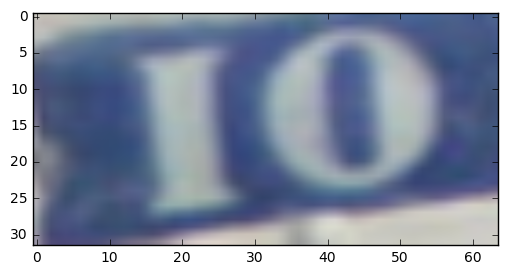

In [79]:
hight = 32
width = 64
image = misc.imread(root_dir + '/data/train/' + to_display)
print (image.shape)
print (get_rectangle_containing_all_digits(labels_train_data_dict[to_display]))
x, y, w, h = get_rectangle_containing_all_digits(labels_train_data_dict[to_display])
image = image[y: y+h, x: x+w]
print (image.shape)
image = misc.imresize(image, (hight, width))
plt.imshow(image)
plt.show()

Resize pictures to 32*64 grayscale and save them into train.pickle and labels into labels_train.pickle.

In [7]:
def rescale(img, l, height, width):
    ph = float(img.shape[0])/height
    pw = float(img.shape[1])/width
    return [l[0], float(l[1])/ph, float(l[2])/pw, float(l[3])/pw, float(l[4])/ph]

In [15]:
pixel_depth = 255.0
hight = 32
width = 64

def save_to_pickle_file(set_filename, folder, labels, force = False):
    if os.path.exists(folder + set_filename) and not force:
        print ('Pickle file ', (folder + set_filename), 'already exists.')
        return
    image_files = os.listdir(root_dir + folder)
    d = dict()
    dataset = np.ndarray(shape=(len(image_files), hight, width), dtype=np.float32)
    num_images = 0
    for image in image_files:
        if not image.endswith('.png'):
            continue
        image_file = os.path.join(root_dir + folder, image)
        try:
            image_orig = ndimage.imread(image_file, flatten=True)
            labels[image].sort(key=lambda x: x[1])
            d[num_images] = [x[0] for x in labels[image]]
            x, y, w, h = get_rectangle_containing_all_digits(labels[image])
            #print (image_file , ':', image_orig.shape, ' -> ', x, y, w, h)
            image_orig = image_orig[y: y+h, x: x+w]
            image_data = (misc.imresize(image_orig, (hight, width)).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (hight, width):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    try:
        pickle.dump(dataset[0:num_images], open(root_dir + folder + set_filename, 'wb'), pickle.HIGHEST_PROTOCOL)
        print ((folder + set_filename), ' saved')
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
        
    try:
        file_name = "labels_" + set_filename
        pickle.dump(d, open( root_dir + folder + file_name, "wb" ))
        print ((folder + file_name), ' saved')
    except Exception as e:
        print('Unable to save data to', file_name, ':', e)
        

save_to_pickle_file('train.pickle', '/data/train/', labels_train_data_dict)
save_to_pickle_file('test.pickle',  '/data/test/', labels_test_data_dict)

/data/train/train.pickle  saved
/data/train/labels_train.pickle  saved
/data/test/test.pickle  saved
/data/test/labels_test.pickle  saved


In [8]:
train_data = pickle.load(open(root_dir + '/data/train/train.pickle', 'rb'))
print (train_data.shape)
labels_train_data = pickle.load(open(root_dir + '/data/train/labels_train.pickle', 'rb'))

test_data = pickle.load(open(root_dir + '/data/test/test.pickle', 'rb'))
print (test_data.shape)
labels_test_data = pickle.load(open(root_dir + '/data/test/labels_test.pickle', 'rb'))

(33402, 32, 64)
(13068, 32, 64)


[1, 10, 9]


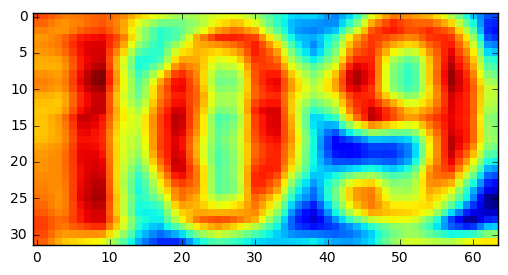

In [9]:
# print (train_data[0]*pixel_depth+pixel_depth/2)
# print (labels_train_data[0])
index = 2
fig,ax = plt.subplots(1)
plt.imshow(train_data[index], interpolation='nearest')
print (labels_train_data[index])
#for digit_loc in labels_train_data[index]:
#    # Create a Rectangle patch
#    rect = patches.Rectangle((digit_loc[1],digit_loc[2]),digit_loc[3],digit_loc[4],linewidth=1,edgecolor='black',facecolor='none')
#    # Add the patch to the Axes
#    ax.add_patch(rect)
plt.show()


In [10]:
digits = 5
labels_train = np.zeros((len(labels_train_data), digits, 11))
labels_only = {x: [y%10 for y in labels_train_data[x]] for x in labels_train_data}
for x in labels_only:
    for i in range(digits-len(labels_only[x])):
        labels_train[x][i][10] = 1
    for i, y in enumerate(labels_only[x]):
        labels_train[x][digits-len(labels_only[x])+i][y] = 1 

index = 0
def get_train_examples(size):
    global index
    index += size
    if index >= train_data.shape[0]:
        index = 0
        return train_data[index-size: train_data.shape[0]], labels_train[index-size: train_data.shape[0]]
    return train_data[index-size:index], labels_train[index-size: index]

def get_test_examples(size, start = 0):
    labels_ = np.zeros((size+start, digits, 11))
    labels_only = {x: [y%10 for y in labels_test_data[x]] for x in labels_test_data}
    for x in range(start + size):
        for i in range(digits-len(labels_only[x])):
            labels_[x][i][10] = 1
        for i, y in enumerate(labels_only[x]):
            labels_[x][i+digits-len(labels_only[x])][y] = 1
    return test_data[start:start+size], labels_[start:start+size]
    

In [11]:
a, b = get_train_examples(1)
print (b[0])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]


In [12]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [19]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse

import tensorflow as tf

FLAGS = None

learning_rate = tf.placeholder(tf.float32, shape=[])

# Create the model
x = tf.placeholder(tf.float32, [None, hight, width]) 
x_image = tf.reshape(x, [-1, hight, width, 1])

keep_prob = tf.placeholder(tf.float32)

## First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 48])
b_conv1 = bias_variable([48])
  
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_lrn1 = tf.nn.lrn(h_pool1)
  
## Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 48, 128])
b_conv2 = bias_variable([128])

h_conv2 = tf.nn.relu(conv2d(h_lrn1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_lrn2 = tf.nn.lrn(h_pool2)

## Third Convolutional Layer
W_conv3 = weight_variable([5, 5, 128, 192])
b_conv3 = bias_variable([192])

h_conv3 = tf.nn.relu(conv2d(h_lrn2, W_conv3) + b_conv3)
h_lrn3 = tf.nn.lrn(h_conv3)

## Forth Convolutional Layer
W_conv4 = weight_variable([3, 3, 192, 192])
b_conv4 = bias_variable([192])

h_conv4 = tf.nn.relu(conv2d(h_lrn3, W_conv4) + b_conv4)
h_lrn4 = tf.nn.lrn(h_conv4)

## Fifth Convolutional Layer
W_conv5 = weight_variable([3, 3, 192, 192])
b_conv5 = bias_variable([192])

h_conv5 = tf.nn.relu(conv2d(h_lrn4, W_conv5) + b_conv5)
h_lrn5 = tf.nn.lrn(h_conv5)

## Densely Connected Layer 1
W_fc1 = weight_variable([hight * width * 12, 2048])
b_fc1 = bias_variable([2048])

h_pool2_flat = tf.reshape(h_lrn5, [-1, hight * width * 12])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Densely Connected Layer 2
W_fc2 = weight_variable([2048, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

## Readout Layer
W_fc3 = weight_variable([2048, 11*digits])
b_fc3 = bias_variable([11*digits])

y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
y_conv_r = tf.reshape(y_conv, [-1, digits, 11])

y = tf.placeholder(tf.float32, [None, digits, 11])
#y_r = tf.reshape(y, [-1, digits, 11])

cross_entropy = tf.reduce_mean(  tf.nn.softmax_cross_entropy_with_logits(y_conv_r[0], y[0]) 
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[1], y[1])
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[2], y[2])
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[3], y[3])
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[4], y[4]))

train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

accuracy_list = list()
loss_list = list()

correct_prediction = tf.equal(tf.argmax(y_conv_r, 2), tf.argmax(y, 2))
accuracy = tf.reduce_mean(tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1))
saver = tf.train.Saver()

In [20]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(2001):
    batch_images, batch_labels = get_train_examples(50)
    lr = 1.0e-4
    loss = train_step.run(feed_dict={x: batch_images, y: batch_labels, keep_prob: 1.0, learning_rate: lr})
    if i%100 == 0:
        batch_images, batch_labels = get_test_examples(2000)
        loss, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={x:batch_images, y: batch_labels, keep_prob: 1.0, learning_rate: lr})
        print("step %d, training accuracy %g, loss %g"%(i, train_accuracy, loss))
        accuracy_list.append(train_accuracy)
        loss_list.append(loss)
        
test_imgs, test_labels = get_test_examples(5000)
print("test accuracy %g"% accuracy.eval(feed_dict={x: test_imgs, y: test_labels, keep_prob: 1.0, learning_rate: 0.0001}))

save_path = saver.save(sess, root_dir + "/tmp/model2.ckpt")
print("Model saved in file: %s" % save_path)

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x118cf5c10>> ignored


step 0, training accuracy 0, loss 215.296
step 100, training accuracy 0.005, loss 33.0598
step 200, training accuracy 0.013, loss 24.6817
step 300, training accuracy 0.0085, loss 18.1915
step 400, training accuracy 0.014, loss 13.3853


KeyboardInterrupt: 

In [ ]:
test_imgs, test_labels = get_test_examples(5000)
print("test accuracy %g"% accuracy.eval(feed_dict={x: test_imgs, y: test_labels, keep_prob: 1.0, learning_rate: 0.0001}))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(0, 2001, 100), accuracy_list, 'r')
plt.show()

In [87]:
saver.restore(sess, root_dir + "/tmp/model.ckpt")
print ("Model restored.")

NotFoundError: Tensor name "Variable_10" not found in checkpoint files /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/tmp/model.ckpt
	 [[Node: save_2/restore_slice_2 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_2/Const_0, save_2/restore_slice_2/tensor_name, save_2/restore_slice_2/shape_and_slice)]]
Caused by op u'save_2/restore_slice_2', defined at:
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-86-987341c1f4e2>", line 68, in <module>
    saver = tf.train.Saver()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 861, in __init__
    restore_sequentially=restore_sequentially)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 519, in build
    filename_tensor, vars_to_save, restore_sequentially, reshape)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 272, in _AddRestoreOps
    values = self.restore_op(filename_tensor, vs, preferred_shard)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 187, in restore_op
    preferred_shard=preferred_shard)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/io_ops.py", line 203, in _restore_slice
    preferred_shard, name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()


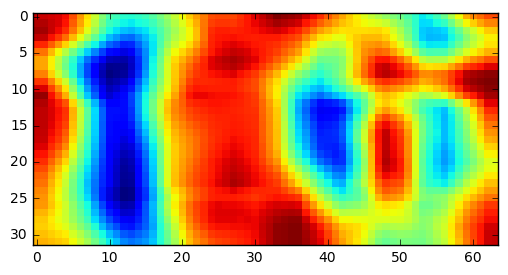

TypeError: Cannot interpret feed_dict key as Tensor: 'numpy.int64' object has no attribute 'name'

In [81]:
def get_test_examples(size, start = 0):
    labels_ = np.zeros((size+start, 5, 11))
    labels_only = {x: [y%10 for y in labels_test_data[x]] for x in labels_test_data}
    for x in range(start + size):
        for i in range(5-len(labels_only[x])):
            labels_[x][i][10] = 1
        for i, y in enumerate(labels_only[x]):
            labels_[x][i+5-len(labels_only[x])][y] = 1
    return test_data[start:start+size], labels_[start:start+size]


def decode(output):
    result = ''
    for x in output:
        if x != 10:
            result = result + str(x)
    return result

test_imgs, test_labels = get_test_examples(1, 1)
# test_imgs, test_labels = get_train_examples(1)
plt.imshow(test_imgs[0], interpolation='nearest')
plt.show()
pred, acc = sess.run([y_conv, accuracy], feed_dict={x:test_imgs, keep_prob: 1.0, learning_rate: 0.0001, y: batch_labels})
print ('accuracy: ', acc)
#confidence = reduce(lambda x, y: x*y, [pred[i][x] for i, x in enumerate(np.argmax(pred, 1))])
#print ('confidence: ', confidence)
pred = tf.reshape(pred, (digits, 11))
pred = tf.nn.softmax(pred)
print (pred)
pred = tf.argmax(pred, 1)
print ('prediction : ', pred)
print ('correct : ', np.argmax(tf.reshape(test_labels, (digits, 11)).eval(), 1))
